In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime, time
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

The following dataset, Google Play Store Apps, is from Kaggle. It was web scraped and was last updated February 3rd, 2019.
There are just over 10,000 entries, each of which is an application available on Google Play Store. We have no target variable (in the spirit of unsupervised learning).

In [47]:
df = pd.read_csv('googleplaystore.csv')
df

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,Sya9a Maroc - FR,FAMILY,4.5,38,53M,"5,000+",Free,0,Everyone,Education,"July 25, 2017",1.48,4.1 and up
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.6M,100+,Free,0,Everyone,Education,"July 6, 2018",1.0,4.1 and up
10838,Parkinson Exercices FR,MEDICAL,NaN,3,9.5M,"1,000+",Free,0,Everyone,Medical,"January 20, 2017",1.0,2.2 and up
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,Varies with device,"1,000+",Free,0,Mature 17+,Books & Reference,"January 19, 2015",Varies with device,Varies with device


In [48]:
df.nunique()

App               9660
Category            34
Rating              40
Reviews           6002
Size               462
Installs            22
Type                 3
Price               93
Content Rating       6
Genres             120
Last Updated      1378
Current Ver       2832
Android Ver         33
dtype: int64

We clean and re-format the data.

"Genre" is multi-valued, including some overlap names with the much smaller (number of unique-value-wise) "Category" feature. We remove the genre feature. "Current Version" and "Android Version" are difficult to work with as well. We remove these three features.

In [49]:
df = df.dropna()

In [50]:
df = df.drop(columns = ['Genres', 'Current Ver', 'Android Ver'], axis=1)

In [51]:
df['Reviews'] = pd.to_numeric(df['Reviews'])

df['Size'] = df['Size'].apply(lambda x:  pd.to_numeric(x.strip('M'))*1000000 if 'M' in x else(
    pd.to_numeric(x.strip('k'))*1000 if 'k' in x else x))

df['Installs'] = df['Installs'].str.strip(to_strip='+')
df['Installs'] = df['Installs'].replace(to_replace=',', value='',regex=True)
df['Installs'] = pd.to_numeric(df['Installs'])

df['Price'] = df['Price'].str.strip(to_strip='$')
df['Price'] = pd.to_numeric(df['Price'])

df['Last Updated'] = pd.to_datetime(df['Last Updated'])
df['Last Updated'] = (df['Last Updated'] - df['Last Updated'].min()).dt.days

In [52]:
df['Size'] = df['Size'].replace(to_replace='Varies with device', value=np.nan, regex=True)
df

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Last Updated
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19000000.0,10000,Free,0.0,Everyone,2788
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14000000.0,500000,Free,0.0,Everyone,2796
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8700000.0,5000000,Free,0.0,Everyone,2994
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25000000.0,50000000,Free,0.0,Teen,2940
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2800000.0,100000,Free,0.0,Everyone,2952
...,...,...,...,...,...,...,...,...,...,...
10834,FR Calculator,FAMILY,4.0,7,2600000.0,500,Free,0.0,Everyone,2585
10836,Sya9a Maroc - FR,FAMILY,4.5,38,53000000.0,5000,Free,0.0,Everyone,2622
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3600000.0,100,Free,0.0,Everyone,2968
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,NaN,1000,Free,0.0,Mature 17+,1704


In [53]:
df.dropna(inplace=True)

In [54]:
df = pd.get_dummies(data=df, columns=['Category', 'Type', 'Content Rating'], drop_first=True)

df = df.drop(['App'], axis=1)
df

,Rating,Reviews,Size,Installs,Price,Last Updated,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,...,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER,Type_Paid,Content Rating_Everyone,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Content Rating_Unrated
0,4.1,159,19000000.0,10000,0.0,2788,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,3.9,967,14000000.0,500000,0.0,2796,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,4.7,87510,8700000.0,5000000,0.0,2994,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4.5,215644,25000000.0,50000000,0.0,2940,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,4.3,967,2800000.0,100000,0.0,2952,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10833,4.8,44,619000.0,1000,0.0,1402,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
10834,4.0,7,2600000.0,500,0.0,2585,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
10836,4.5,38,53000000.0,5000,0.0,2622,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
10837,5.0,4,3600000.0,100,0.0,2968,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


We re-index and normalize the data, so that we can finally apply clustering algorithms!

In [55]:
df = df.reset_index(drop=True)

# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(df)
X_std

array([[-0.13575945, -0.15813783, -0.16932947, ..., -0.22368279,
        -0.35584112, -0.01137981],
       [-0.50299945, -0.15770431, -0.38256626, ..., -0.22368279,
        -0.35584112, -0.01137981],
       [ 0.96596057, -0.11127099, -0.60859727, ..., -0.22368279,
        -0.35584112, -0.01137981],
       ...,
       [ 0.59872056, -0.15820275,  1.28068074, ..., -0.22368279,
        -0.35584112, -0.01137981],
       [ 1.51682058, -0.15822099, -0.8260988 , ..., -0.22368279,
        -0.35584112, -0.01137981],
       [ 0.59872056,  0.05548237, -0.16932947, ..., -0.22368279,
        -0.35584112, -0.01137981]])

For visualization purposes, we apply feature reduction techniques (two components each) which include PCA, t-SNE, and UMAP. We plot all three of these.

In [56]:
time_start = time.time()
X_pca = PCA(n_components=2).fit_transform(X_std)

print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))

PCA done! Time elapsed: 0.02698230743408203 seconds


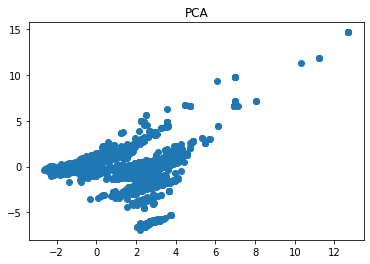

In [57]:
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title('PCA')
plt.show()

In [58]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
X_tsne = tsne.fit_transform(X_std)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7723 samples in 0.091s...
[t-SNE] Computed neighbors for 7723 samples in 4.035s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7723
[t-SNE] Computed conditional probabilities for sample 2000 / 7723
[t-SNE] Computed conditional probabilities for sample 3000 / 7723
[t-SNE] Computed conditional probabilities for sample 4000 / 7723
[t-SNE] Computed conditional probabilities for sample 5000 / 7723
[t-SNE] Computed conditional probabilities for sample 6000 / 7723
[t-SNE] Computed conditional probabilities for sample 7000 / 7723
[t-SNE] Computed conditional probabilities for sample 7723 / 7723
[t-SNE] Mean sigma: 0.489171
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.478012
[t-SNE] KL divergence after 300 iterations: 1.590531
t-SNE done! Time elapsed: 25.473392248153687 seconds


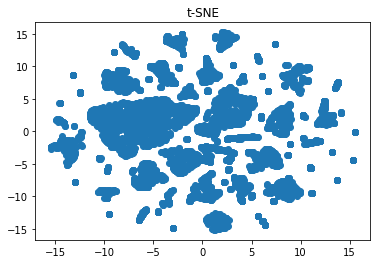

In [59]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.title("t-SNE")
plt.show()

In [60]:
time_start = time.time()
X_umap = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))

C:\Users\Cody Martin\Anaconda3\lib\site-packages\numba\compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\..\Anaconda3\lib\site-packages\umap\nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
C:\Users\Cody Martin\Anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 111 separate connected components using meta-embedding (experimental)
  n_components


UMAP done! Time elapsed: 10.187119960784912 seconds


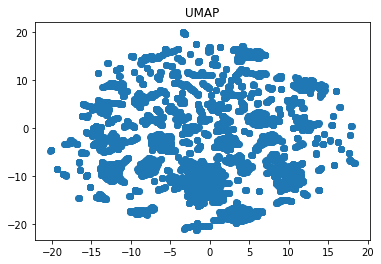

In [62]:
plt.scatter(X_umap[:, 0], X_umap[:, 1])
plt.title("UMAP")
plt.show()

Very roughly speaking, there appears to be around 6 clusters in the PCA reduction, 15-25 clusters in the t-SNE reduction, and 15-30 clusters in the UMAP reduction.

First we apply K-means clustering. We plot each feature reduction for 2-6 clusters.

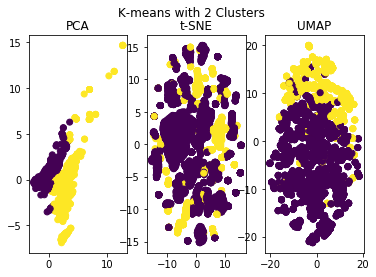

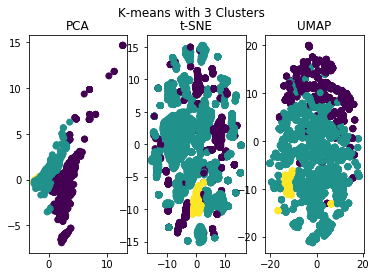

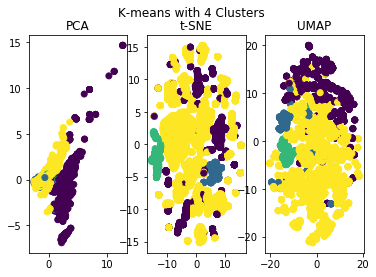

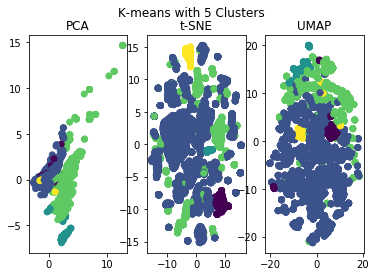

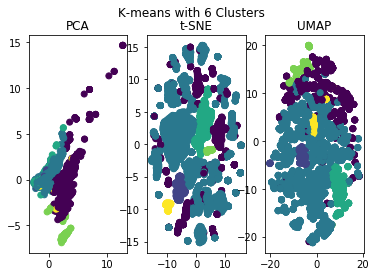

In [67]:
for i in range(2,7):
    
    # Defining the k-means
    kmeans = KMeans(n_clusters=i)

    # Fit model
    kmeans.fit(X_std)
    y_pred = kmeans.predict(X_std)
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 3)
    
    axarr[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
    axarr[0].set_title('PCA')
    axarr[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_pred)
    axarr[1].set_title('t-SNE')
    axarr[2].scatter(X_umap[:, 0], X_umap[:, 1], c=y_pred)
    axarr[2].set_title('UMAP')
    
    plt.suptitle('K-means with {} Clusters'.format(i))
    plt.show()

Beyond 6 clusters, the visualizations are not very helpful.
Also, there doesn't appear to be any useful clustering from K-means (visual-wise).

We compute the silhouette scores for K-means with 2-80 clusters.

In [85]:
# array to store silhouette scores for K-means with k ranging from 2 to 80.
sil = []

for i in range(2,81):
    
    # Defining the k-means
    kmeans = KMeans(n_clusters=i)

    # Fit model
    kmeans.fit(X_std)
    y_pred = kmeans.predict(X_std)
    
    score = metrics.silhouette_score(X_std, y_pred, metric='euclidean')
    sil.append(score)

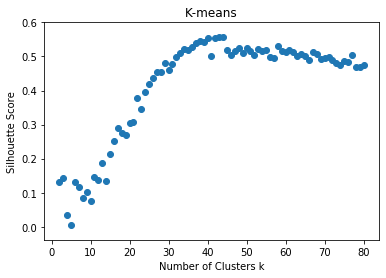

In [90]:
x = list(range(2,81))

plt.scatter(x,sil)
plt.title("K-means")
plt.xlabel("Number of Clusters k")
plt.ylabel("Silhouette Score")
plt.show()

In [88]:
max(sil)

0.5572579102192261

The best scores appear to be when k is around 40.

In [87]:
for i in range(28,79):
    print(x[i],sil[i])

30 0.45931284925216803
31 0.4786443377182798
32 0.49734831556201187
33 0.5107789789453641
34 0.5221310806214164
35 0.5186440407819118
36 0.5285385047590719
37 0.5398781251476138
38 0.5465827136554139
39 0.5416411607926721
40 0.5532886208404157
41 0.5015368213930578
42 0.5554705901028221
43 0.556305509475803
44 0.5572579102192261
45 0.5182357274851623
46 0.5039522522797819
47 0.5172850362019479
48 0.5235067142664366
49 0.5109879406396862
50 0.5236474829024229
51 0.5160182445554404
52 0.5036049202031491
53 0.5232189490756443
54 0.5162977351464103
55 0.5175267277840286
56 0.498074267885806
57 0.49672914890355685
58 0.5307738631088823
59 0.5150589406941116
60 0.5138298694055636
61 0.5179571548210541
62 0.513332192680512
63 0.5000835550634418
64 0.5063483697645733
65 0.5001513982253601
66 0.488720291215394
67 0.5133726097489161
68 0.5069918076646571
69 0.49235162019712664
70 0.49620307058282
71 0.4989025781412738
72 0.48877572093012295
73 0.4801068996667077
74 0.4745736939420525
75 0.486017

k=44 cluters with a silhouette score of 0.557 is our maximum; however it is worth noting that the silhouette score is above 0.5 when k=33.

Next we move to agglomerative clustering. We try 2-10 clusters and three different linkage methods.

In [98]:
#Agglovmerative Clustering
for i in range(2,11):

    # Defining the agglomerative clustering
    agg_cluster = AgglomerativeClustering(linkage="average", 
                                      affinity='cosine',
                                      n_clusters=i)
    clusters = agg_cluster.fit_predict(X_std)
    print("Silhouette score with {} clusters and average linkage method: {}".format(i,
        metrics.silhouette_score(X_std, clusters, metric='euclidean')))


    # Defining the agglomerative clustering
    agg_cluster = AgglomerativeClustering(linkage="complete", 
                                      affinity='cosine',
                                      n_clusters=i)
    clusters = agg_cluster.fit_predict(X_std)
    print("Silhouette score with {} clusters and complete linkage method: {}".format(i,
        metrics.silhouette_score(X_std, clusters, metric='euclidean')))


    # Defining the agglomerative clustering
    agg_cluster = AgglomerativeClustering(linkage="ward", 
                                      affinity='euclidean',
                                      n_clusters=i)
    clusters = agg_cluster.fit_predict(X_std)
    print("Silhouette score with {} clusters and ward linkage method: {}".format(i,
        metrics.silhouette_score(X_std, clusters, metric='euclidean')))
    print("------------------------------------------------------------")

Silhouette score with 2 clusters and average linkage method: 0.07411977044675469
Silhouette score with 2 clusters and complete linkage method: -0.30430144884520627
Silhouette score with 2 clusters and ward linkage method: 0.05170324258182568
------------------------------------------------------------
Silhouette score with 3 clusters and average linkage method: -0.0598002733047168
Silhouette score with 3 clusters and complete linkage method: -0.20768868060400525
Silhouette score with 3 clusters and ward linkage method: 0.06268901858598551
------------------------------------------------------------
Silhouette score with 4 clusters and average linkage method: -0.04201802516971772
Silhouette score with 4 clusters and complete linkage method: -0.1750172270588272
Silhouette score with 4 clusters and ward linkage method: 0.06169818899800734
------------------------------------------------------------
Silhouette score with 5 clusters and average linkage method: -0.019556410597816862
Silhouet

Ward seems to be the best linkage method consistently, and complete performs the worst. Now we will fix the ward linkage method and get visualizations of the agglomerative clustering with the first two components of the three feature reduction methods used above.

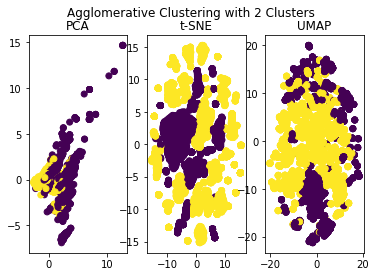

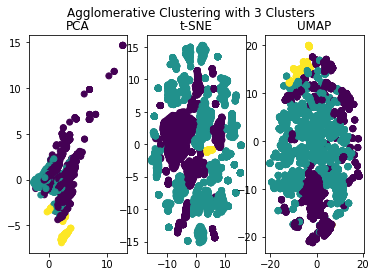

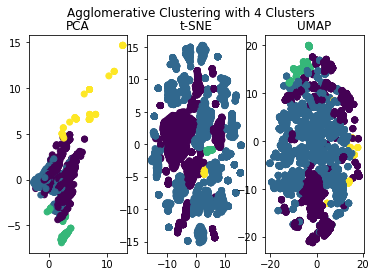

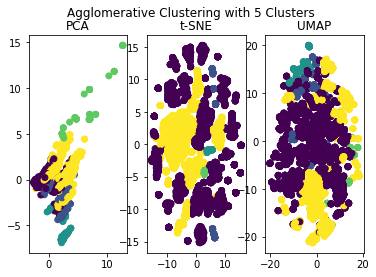

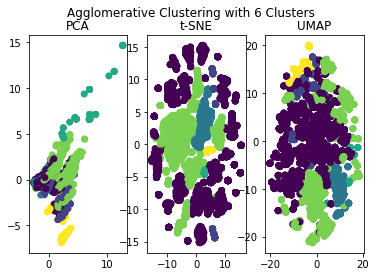

In [100]:
for i in range(2,7):
    
    agg_cluster = AgglomerativeClustering(linkage="ward", 
                                      affinity='euclidean',
                                      n_clusters=i)
    clusters = agg_cluster.fit_predict(X_std)
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 3)
    
    axarr[0].scatter(X_pca[:, 0], X_pca[:, 1], c=clusters)
    axarr[0].set_title('PCA')
    axarr[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters)
    axarr[1].set_title('t-SNE')
    axarr[2].scatter(X_umap[:, 0], X_umap[:, 1], c=clusters)
    axarr[2].set_title('UMAP')
    
    plt.suptitle('Agglomerative Clustering with {} Clusters'.format(i))
    plt.show()

With the ward linkage method, we compute the sihouette score of the agglomerative clustering with varying the number of clusters from 2 to 80

In [101]:
# array to store silhouette scores for agglomerative clustering with clusters ranging from 2 to 80.
sil = []

for i in range(2,81):
    
    agg_cluster = AgglomerativeClustering(linkage="ward", 
                                      affinity='euclidean',
                                      n_clusters=i)
    clusters = agg_cluster.fit_predict(X_std)
    
    score = metrics.silhouette_score(X_std, clusters, metric='euclidean')
    sil.append(score)

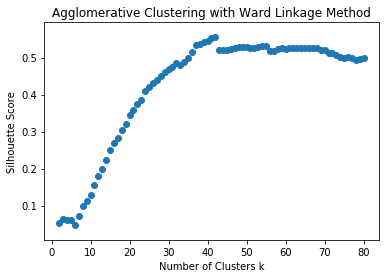

In [102]:
plt.scatter(x,sil)
plt.title("Agglomerative Clustering with Ward Linkage Method")
plt.xlabel("Number of Clusters k")
plt.ylabel("Silhouette Score")
plt.show()

In [103]:
max(sil)

0.5544783617048685

In [104]:
for i in range(28,79):
    print(x[i],sil[i])

30 0.4682213035564447
31 0.47424705106964316
32 0.48640235689000505
33 0.4804571361539454
34 0.48741017173488393
35 0.49759497240850603
36 0.5150054026560326
37 0.5326130955812041
38 0.5365737779179751
39 0.5431295278848407
40 0.544001589699832
41 0.5522770748960899
42 0.5544783617048685
43 0.5190114199767182
44 0.5197870027225658
45 0.5208898791682559
46 0.5226672205655339
47 0.5263284086285875
48 0.5274802714002972
49 0.5283147304523802
50 0.527949979286137
51 0.5245359135969504
52 0.5251992120912358
53 0.5294634263708012
54 0.5319282414444698
55 0.5324466032419991
56 0.5165072481560877
57 0.5183462047434991
58 0.5233598672387211
59 0.5261326056313714
60 0.5228606740965079
61 0.5243794190834067
62 0.5260183011779122
63 0.5259721340320016
64 0.5250169471812639
65 0.5269782519454426
66 0.525915237170618
67 0.5266516562798125
68 0.5261839034320914
69 0.5201493625219189
70 0.5208769315150138
71 0.513344343960706
72 0.5115385775018094
73 0.5055062850841208
74 0.501162358840799
75 0.499295

42 cluters with a silhouette score of 0.554 is our maximum for agglomerative clustering; however, it is worth noting that the silhouette score is above 0.5 when k=36. This is very analogous to K-means. Even the high number of clusters (over 40) yielding an optimal silhouette score is similar.

Now we try DBSCAN. First we vary the value of epsilon while fixing minimal points in neighbor at five.

In [117]:
for i in range(1,16):
    
    dbscan_cluster = DBSCAN(eps=i, min_samples=5)
    clusters = dbscan_cluster.fit_predict(X_std)
    print("The number of clusters is {} when epsilon is {}".format(len(np.unique(clusters)),i))
    print("The silhouette score is {}".format(
        metrics.silhouette_score(X_std, clusters, metric='euclidean')))
    print("------------------------------------------------------------")

The number of clusters is 89 when epsilon is 1
The silhouette score is 0.3888348355960564
------------------------------------------------------------
The number of clusters is 91 when epsilon is 2
The silhouette score is 0.49201182364381263
------------------------------------------------------------
The number of clusters is 94 when epsilon is 3
The silhouette score is 0.5414236437544839
------------------------------------------------------------
The number of clusters is 67 when epsilon is 4
The silhouette score is 0.4794181416501799
------------------------------------------------------------
The number of clusters is 53 when epsilon is 5
The silhouette score is 0.45747524059399597
------------------------------------------------------------
The number of clusters is 27 when epsilon is 6
The silhouette score is 0.3342816149554729
------------------------------------------------------------
The number of clusters is 20 when epsilon is 7
The silhouette score is 0.28803606700339346
-

With epsilon = 15, we have just 2 clusters. The silhouette score is very high at 0.9015.

We now vary the minimal points in an epsilon neighborhood (with fixing epsilon = 15).

In [120]:
for i in range(1,6):
    
    dbscan_cluster = DBSCAN(eps=15, min_samples=2*i)
    clusters = dbscan_cluster.fit_predict(X_std)
    print("The number of clusters is {} when the minimal number of points in an epsilon neighboorhood is {}".format(
        len(np.unique(clusters)),2*i))
    print("The silhouette score is {}".format(
        metrics.silhouette_score(X_std, clusters, metric='euclidean')))
    print("------------------------------------------------------------")

The number of clusters is 2 when the minimal number of points in an epsilon neighboorhood is 2
The silhouette score is 0.9015270905665252
------------------------------------------------------------
The number of clusters is 2 when the minimal number of points in an epsilon neighboorhood is 4
The silhouette score is 0.9015270905665252
------------------------------------------------------------
The number of clusters is 2 when the minimal number of points in an epsilon neighboorhood is 6
The silhouette score is 0.9015270905665252
------------------------------------------------------------
The number of clusters is 2 when the minimal number of points in an epsilon neighboorhood is 8
The silhouette score is 0.9015270905665252
------------------------------------------------------------
The number of clusters is 2 when the minimal number of points in an epsilon neighboorhood is 10
The silhouette score is 0.9015270905665252
------------------------------------------------------------


Varying this parameter while epsilon is 15 did not affect anything.

with the optimal two clusters from DBSCAN, we get a visualization with the first two components of PCA, t-SNE, and UMAP.

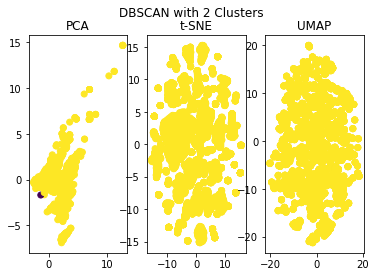

In [122]:
dbscan_cluster = DBSCAN(eps=15, min_samples=5)
clusters = dbscan_cluster.fit_predict(X_std)
    
# Make a grid of subplots.
f, axarr = plt.subplots(1, 3)

axarr[0].scatter(X_pca[:, 0], X_pca[:, 1], c=clusters)
axarr[0].set_title('PCA')
axarr[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters)
axarr[1].set_title('t-SNE')
axarr[2].scatter(X_umap[:, 0], X_umap[:, 1], c=clusters)
axarr[2].set_title('UMAP')

plt.suptitle('DBSCAN with 2 Clusters')
plt.show()

In [125]:
series = pd.Series(clusters)
series.value_counts()

 0    7722
-1       1
dtype: int64

The two clusters are useless, since one of the clusters is just a single point! Let's backup to epsilon=14, where there are five clusters.

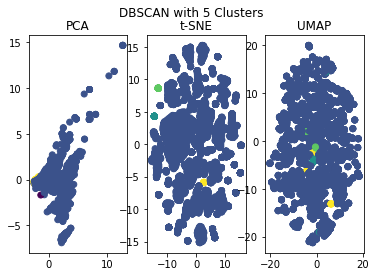

In [128]:
dbscan_cluster = DBSCAN(eps=14, min_samples=5)
clusters = dbscan_cluster.fit_predict(X_std)
    
# Make a grid of subplots.
f, axarr = plt.subplots(1, 3)

axarr[0].scatter(X_pca[:, 0], X_pca[:, 1], c=clusters)
axarr[0].set_title('PCA')
axarr[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters)
axarr[1].set_title('t-SNE')
axarr[2].scatter(X_umap[:, 0], X_umap[:, 1], c=clusters)
axarr[2].set_title('UMAP')

plt.suptitle('DBSCAN with 5 Clusters')
plt.show()

In [129]:
series = pd.Series(clusters)
series.value_counts()

 0    7632
 2      38
 1      37
 3      15
-1       1
dtype: int64

It appears with the high epsilon values, that all but a few points are lumped in a single cluster. Note that there were fairly high silhouette scores (comparatively) when epsilon was between 2 and 5. We backup and retune from there.

In [132]:
for i in range(2,6):
    for j in range(1,6):
        dbscan_cluster = DBSCAN(eps=i, min_samples=2*j)
        clusters = dbscan_cluster.fit_predict(X_std)
        print("Epsilon is {}, and the minimal number of points in an epsilon neighboorhood is {}".format(i,2*j))
        print("The silhouette score is {}".format(
            metrics.silhouette_score(X_std, clusters, metric='euclidean')))
        print("------------------------------------------------------------")
    print("------------------------------------------------------------")
    print("------------------------------------------------------------")

Epsilon is 2, and the minimal number of points in an epsilon neighboorhood is 2
The silhouette score is 0.49048858316294824
------------------------------------------------------------
Epsilon is 2, and the minimal number of points in an epsilon neighboorhood is 4
The silhouette score is 0.49882348638921425
------------------------------------------------------------
Epsilon is 2, and the minimal number of points in an epsilon neighboorhood is 6
The silhouette score is 0.48933727875640637
------------------------------------------------------------
Epsilon is 2, and the minimal number of points in an epsilon neighboorhood is 8
The silhouette score is 0.4853002094369627
------------------------------------------------------------
Epsilon is 2, and the minimal number of points in an epsilon neighboorhood is 10
The silhouette score is 0.4806312063189399
------------------------------------------------------------
------------------------------------------------------------
---------------

Our best silhouette score for DBSCAN is 0.547, when epsilon is 3 and the minimal number of points is 2.

In [134]:
dbscan_cluster = DBSCAN(eps=3, min_samples=2)
clusters = dbscan_cluster.fit_predict(X_std)

print(format(len(np.unique(clusters))))

134


With this number of clusters, a visual for intuition wouldn't be too useful.

Finally, for our last clustering algorithm we apply GMM.

In [146]:
# array to store silhouette scores for GMM with clusters ranging from 2 to 80.
sil = []

for i in range (2,81):
    gmm_cluster = GaussianMixture(n_components=i)
    clusters = gmm_cluster.fit_predict(X_std)
    score = metrics.silhouette_score(X_std, clusters, metric='euclidean')
    sil.append(score)

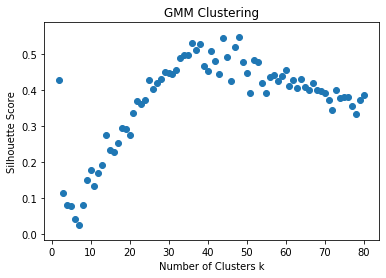

In [147]:
plt.scatter(x,sil)
plt.title("GMM Clustering")
plt.xlabel("Number of Clusters k")
plt.ylabel("Silhouette Score")
plt.show()

In [148]:
max(sil)

0.5465296697977697

In [149]:
for i in range(28,79):
    print(x[i],sil[i])

30 0.44682157579820536
31 0.44546165679416544
32 0.4563416661202441
33 0.48843174533132633
34 0.49834786387839936
35 0.49820977103105374
36 0.5315130098947323
37 0.511498270720094
38 0.5284564575769642
39 0.4674625858110652
40 0.451460992916325
41 0.507423174611451
42 0.48150626756544185
43 0.4444676329907943
44 0.5447288490383794
45 0.49085414277232553
46 0.4258563332674225
47 0.5186947746402765
48 0.5465296697977697
49 0.47654709546535917
50 0.4481685458217551
51 0.39264759280056505
52 0.4829290007027854
53 0.47717153389039985
54 0.4178446890212483
55 0.39191543531344425
56 0.4355013507955071
57 0.44174159478735747
58 0.4240833082044639
59 0.4374195059159109
60 0.45479659612101325
61 0.41203185982752755
62 0.4266887375197169
63 0.40613390670101185
64 0.43157876510389953
65 0.4067048273171896
66 0.4003877487579283
67 0.4182430861284886
68 0.3988698680249933
69 0.39591128716154905
70 0.39173381892763237
71 0.37079362910251995
72 0.3441573535236771
73 0.39831723526760276
74 0.3760556815

48 clusters gives us the best silhouette score for GMM at 0.5465.

Other than DBSCAN, the best number of clusters for the clustering algorithms appears to be in the 40s. K-means had the highest score at 0.557, but note that the best sihouette scores we achieved for each of the four algorithm are all within 0.55 plus or minus 0.01. There is no clear winner here. Getting a best score of less than 0.56 (along with very high number of clusters) might indicate that the data is very noisy, and it's not clear if the clustering techniques are very useful here. Furthermore, there is no good visualization with so many clusters. The feature reduction techniques gave very little intuition (if not none) for this dataset for picturing clusters.